# MicroTPCT – Matching Algorithm Benchmark Notebook

This notebook benchmarks several exact peptide-to-proteome matching algorithms implemented in MicroTPCT.  
We evaluate execution time, CPU usage, peak memory consumption, and correctness in order to guide default algorithm selection and user-level configuration.

## Introduction

This benchmark evaluates several exact peptide-to-proteome matching strategies implemented in MicroTPCT.

The objectives are:

- Compare execution time, CPU usage, and peak memory consumption across multiple algorithms.
- Verify correctness against a reference method.
- Characterize algorithmic behavior under different scenarios.
- Provide practical guidance for default algorithm selection and user-level configuration.

The following algorithms are compared:

- Naive Python baseline (`str.find`) (reference method)
- Boyer–Moore
- Aho–Corasick (pure Python implementation)
- Aho–Corasick (Rust backend)
- System-level `grep + awk` launcher
- BLAST (included as a qualitative reference, not as a competitive exact matcher)

## 1. Imports and configuration

### 1.1 Imports

In [13]:
from typing import List
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from microtpct.utils.data_generator import generate_benchmark_databases
from microtpct.core.match import get_engine, list_available_engines
from microtpct.io.writers import _sanitize_name

from benchmark_core import BenchmarkResult, run_benchmark

### 1.2 System and execution environment

In order to ensure reproducibility and allow proper interpretation of performance results, we report the hardware and software environment used for this benchmark.

In [14]:
import platform, sys, psutil

print("System:", platform.platform())
print("Python:", sys.version)
print("CPU:", platform.processor())
print("Cores:", psutil.cpu_count(logical=True))
print("RAM (GB):", round(psutil.virtual_memory().total / 1e9, 2))

System: Linux-6.8.0-90-generic-x86_64-with-glibc2.39
Python: 3.12.3 (main, Jan  8 2026, 11:30:50) [GCC 13.3.0]
CPU: x86_64
Cores: 8
RAM (GB): 6.14


## 2. Benchmark scenarios

We define a limited set of synthetic scenarios designed to expose algorithmic differences without performing an exhaustive grid search.

Each scenario controls:

- Proteome size and length distribution  
- Number and length of peptides  
- Match density  
- Sequence redundancy  

These scenarios aim to reproduce both realistic use cases and stress conditions.

In [15]:
SCENARIOS = {
    "small_sparse": dict(
        n_proteins=1000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=1000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.05,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=1,
    ),

    "many_queries": dict(
        n_proteins=5000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=20000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.1,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=2,
    ),

    "short_peptides": dict(
        n_proteins=2000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=3000,
        peptide_mean_length=6,
        peptide_std_length=1,
        match_fraction=0.3,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=3,
    ),

    "negative_only": dict(
        n_proteins=5000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=5000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.0,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=4,
    ),

    "repetitive": dict(
        n_proteins=2000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=1000,
        peptide_mean_length=7,
        peptide_std_length=1,
        match_fraction=0.8,
        quasi_fraction=0.0,
        redundancy_rate=0.3,
        mutation_rate=0.05,
        seed=5,
    ),
}

## 3. Register algorithms

We retrieve all matching engines currently available in MicroTPCT.  
The naive `str.find` implementation is used as a baseline reference for correctness and relative performance.

All algorithms are evaluated using the same input databases and compared against a common ground truth.

In [16]:
reference_engine = "find"
engines_to_test = list_available_engines(add_blast=True)
engines_to_test.remove('boyer_moore')
engines_to_test

['aho', 'aho_rs', 'blast', 'find']

## 4. Perform benchmark

For each scenario, we generate a fully controled synthetic target proteome and a set of query peptides.

Each matching algorithm is then executed on the same input databases and evaluated using the following metrics:

- Wall-clock execution time
- CPU utilization
- Peak resident memory consumption
- Result correctness compared to the reference method (`str.find`)

Each algorithm is executed 3 times and results are averaged.

All benchmarks are executed sequentially in the same Python process in order to minimize variability due to process startup and I/O overhead.

In [17]:
reference_func = get_engine(reference_engine)

all_results: list[BenchmarkResult] = []

for scenario_name, params in SCENARIOS.items():
    print(f"Running scenario: {scenario_name}")

    # Database generation
    target_db, query_db, config = generate_benchmark_databases(**params)

    reference = reference_func(target_db, query_db)
    print(engines_to_test)
    # Loop over selected matching engine (by default: all available)
    for engine_name in engines_to_test:
        print(f"  Algorithm: {engine_name}")

        # Dynamically get the matching function
        algo_func = get_engine(engine_name)

        # Benchmark
        res = run_benchmark(
            algorithm_name=engine_name,
            run_method=algo_func,
            scenario_name=scenario_name,
            target_db=target_db,
            query_db=query_db,
            reference=reference,
            n_run=3
        )

        all_results.append(res)


# Convert result to DataFrame

df = pd.DataFrame([r.__dict__ for r in all_results])
df


Running scenario: small_sparse
['aho', 'aho_rs', 'blast', 'find']
  Algorithm: aho
  Algorithm: aho_rs
  Algorithm: blast
  Algorithm: find
Running scenario: many_queries
['aho', 'aho_rs', 'blast', 'find']
  Algorithm: aho
  Algorithm: aho_rs
  Algorithm: blast
  Algorithm: find
Running scenario: short_peptides
['aho', 'aho_rs', 'blast', 'find']
  Algorithm: aho
  Algorithm: aho_rs
  Algorithm: blast
  Algorithm: find
Running scenario: negative_only
['aho', 'aho_rs', 'blast', 'find']
  Algorithm: aho
  Algorithm: aho_rs
  Algorithm: blast
  Algorithm: find
Running scenario: repetitive
['aho', 'aho_rs', 'blast', 'find']
  Algorithm: aho
  Algorithm: aho_rs
  Algorithm: blast
  Algorithm: find


,algorithm,scenario,n_targets,n_queries,wall_time,cpu_user_time,cpu_system_time,cpu_total_time,cpu_utilization,peak_memory_mb,n_matches,valid
0,aho,small_sparse,1000,1000,0.025033,0.023333,0.000000,0.023333,0.932106,0.359425,56,True
1,aho_rs,small_sparse,1000,1000,0.006353,0.006667,0.000000,0.006667,1.049414,0.046025,56,True
2,blast,small_sparse,1000,1000,1.072216,0.123333,0.010000,0.133333,0.124353,1.367877,3125,False
3,find,small_sparse,1000,1000,0.425583,0.420000,0.000000,0.420000,0.986882,0.046207,56,True
4,aho,many_queries,5000,20000,0.908420,0.886667,0.020000,0.906667,0.998070,8.119048,13844,True
5,aho_rs,many_queries,5000,20000,0.330279,0.330000,0.000000,0.330000,0.999156,1.441861,13844,True
6,blast,many_queries,5000,20000,36.974998,2.540000,0.206667,2.746667,0.074284,27.957103,55253,False
7,find,many_queries,5000,20000,57.460131,57.410000,0.006667,57.416667,0.999244,1.442444,13844,True
8,aho,short_peptides,2000,3000,0.112319,0.113333,0.000000,0.113333,1.009033,1.068935,4951,True
9,aho_rs,short_peptides,2000,3000,0.054843,0.053333,0.000000,0.053333,0.972480,0.514874,4951,True


## 5. Sanity check: correctness

All algorithms are validated against the reference ground truth (made by `str.find`).  
Any mismatch would indicate an implementation error or undefined behavior.

This assertion guarantees that all reported performance metrics correspond to correct matching results.

In [18]:
assert df["valid"].all(), "Some algorithms produced incorrect results"

AssertionError: Some algorithms produced incorrect results

## 6. Visualization

We now visualize the benchmark results in order to compare algorithmic performance across scenarios.

All figures are automatically exported and in order to be included in the MicroTPCT documentation and README.

### 6.0 Configure figures saving parameters

In [19]:
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

def save_fig(name: str, dpi: int = 300):
    path = FIGURES_DIR / f"{_sanitize_name(name)}.png"
    plt.savefig(path, bbox_inches="tight", dpi=dpi)
    print(f"Saved figure: {path}")

### 6.1 Execution time

Saved figure: figures/execution_time_per_algorithm_and_scenario.png


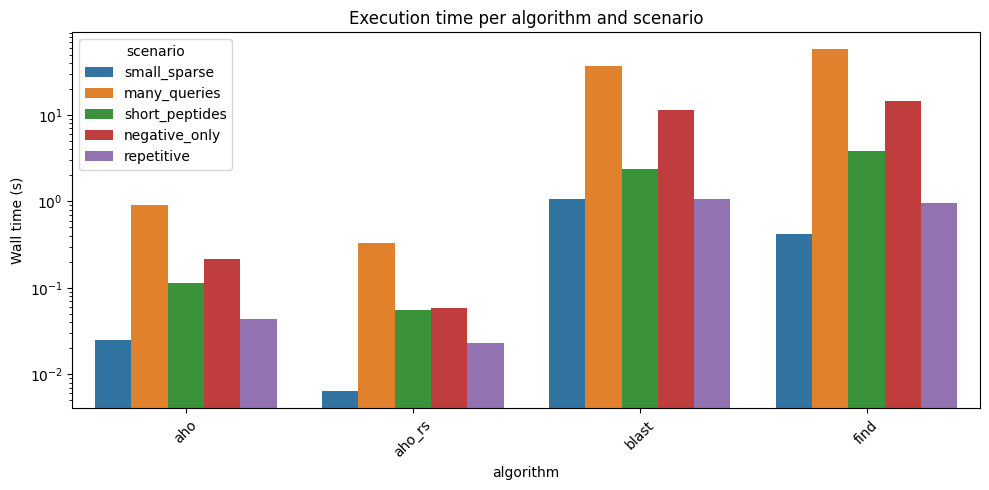

In [20]:
title = "Execution time per algorithm and scenario"

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="algorithm", y="wall_time", hue="scenario")
plt.ylabel("Wall time (s)")
plt.yscale("log")
plt.title(title)
plt.xticks(rotation=45)
plt.tight_layout()
save_fig(title)
plt.show()

### 6.2 Peak memory

Saved figure: figures/peak_memory_consumption_per_algorithm_and_scenario.png


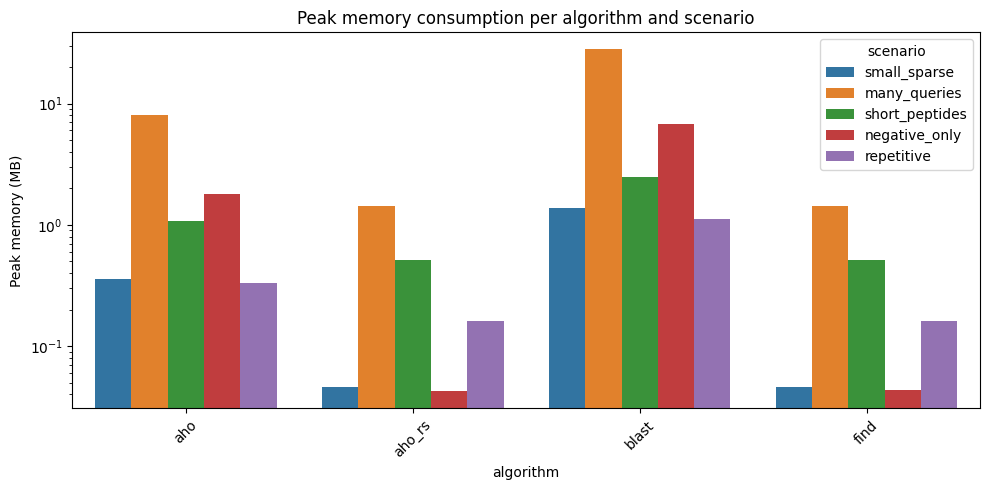

In [27]:
title = "Peak memory consumption per algorithm and scenario"

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="algorithm", y="peak_memory_mb", hue="scenario")
plt.ylabel("Peak memory (MB)")
plt.yscale("log")
plt.title(title)
plt.xticks(rotation=45)
plt.tight_layout()
save_fig(title)
plt.show()

### 6.3 CPU usage

Saved figure: figures/cpu_utilization_per_algorithm_and_scenario.png


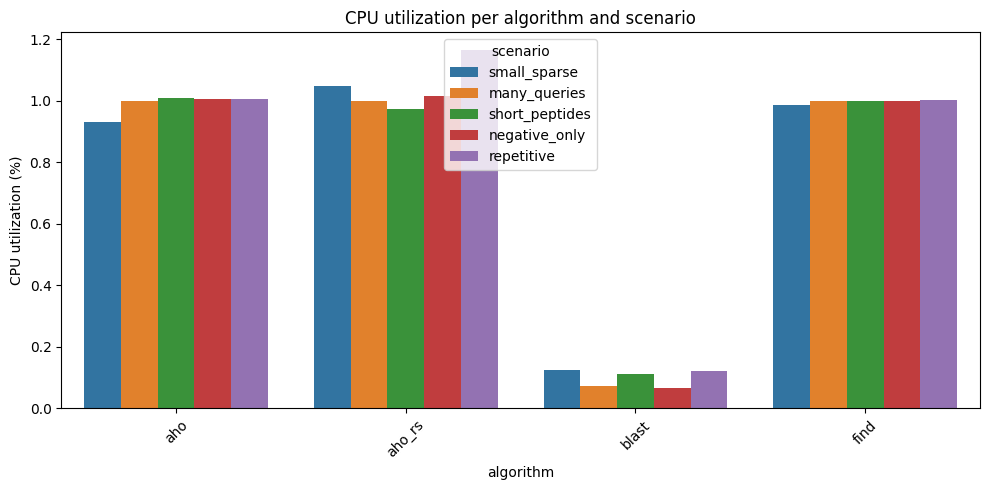

In [22]:
title = "CPU utilization per algorithm and scenario"

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="algorithm", y="cpu_utilization", hue="scenario")
plt.ylabel("CPU utilization (%)")
plt.title(title)
plt.xticks(rotation=45)
plt.tight_layout()
save_fig(title)
plt.show()

### 6.4 Speed–Memory trade-off

Saved figure: figures/peak_memory_consumption_per_algorithm_and_scenario.png


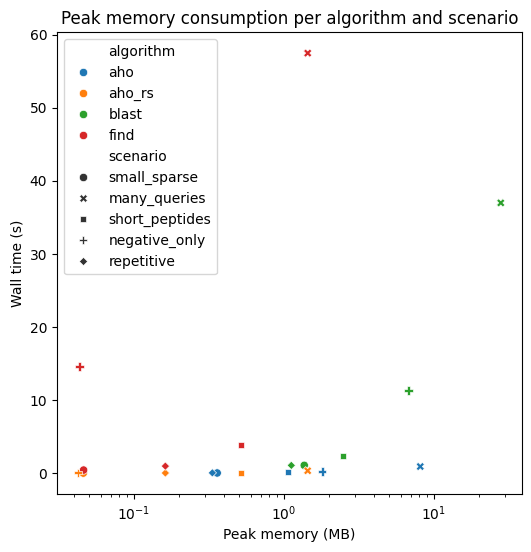

In [30]:
Title = "Speed–Memory trade-off"

plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="peak_memory_mb", y="wall_time", hue="algorithm", style="scenario")
plt.xscale("log")
plt.xlabel("Peak memory (MB)")
plt.ylabel("Wall time (s)")
plt.title(title)
save_fig(title)
plt.show()

### 6.5 Scaling behaviors

Saved figure: figures/wall_time_scaling_with_number_of_peptides.png


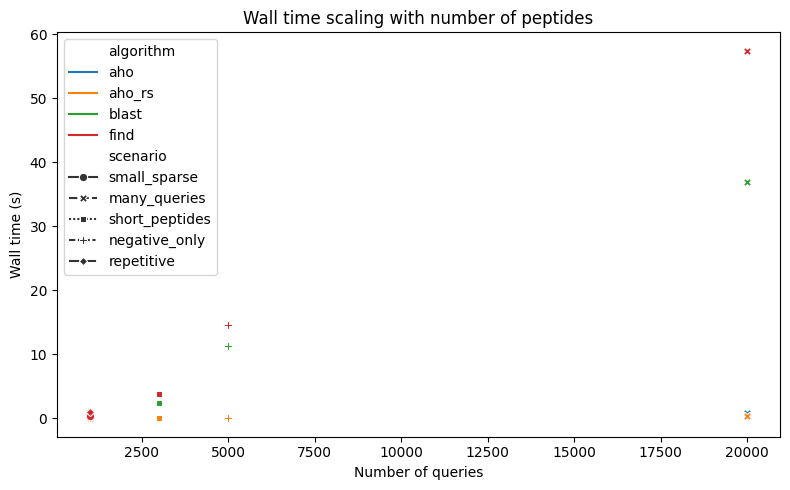

In [24]:
title = "Wall time scaling with number of peptides"

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="n_queries", y="wall_time", hue="algorithm", style="scenario", markers=True)
plt.xlabel("Number of queries")
plt.ylabel("Wall time (s)")
plt.title(title)
plt.tight_layout()
save_fig(title)
plt.show()

Saved figure: figures/peak_memory_scaling_with_number_of_peptides.png


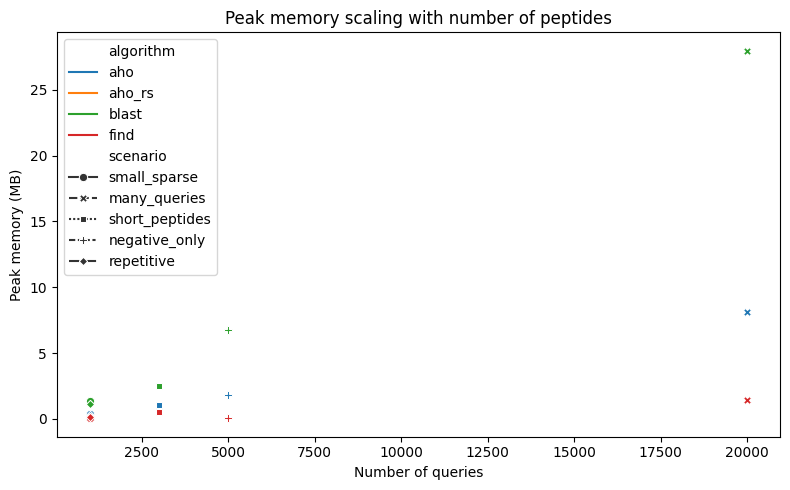

In [25]:
title = "Peak memory scaling with number of peptides"

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="n_queries", y="peak_memory_mb", hue="algorithm", style="scenario", markers=True)
plt.xlabel("Number of queries")
plt.ylabel("Peak memory (MB)")
plt.title(title)
plt.tight_layout()
save_fig(title)
plt.show()

## 7. Key observations (to be completed)

* Scenario: small_sparse

  * [Placeholder: comment on relative speed and overhead]

* Scenario: short_peptides

  * [Placeholder: collision behavior, advantage of multi-pattern algorithms]

* Scenario: negative_only

  * [Placeholder: worst-case scanning cost]

## 8. Summary table

In [26]:
summary = (
    df.groupby(["algorithm"])
      .agg({
          "wall_time": "mean",
          "peak_memory_mb": "mean",
          "cpu_user_time": "mean",
          "valid": "all",
      })
      .reset_index()
)
summary

,algorithm,wall_time,peak_memory_mb,cpu_user_time,valid
0,aho,0.260796,2.337075,0.256667,True
1,aho_rs,0.094712,0.441468,0.095333,True
2,blast,10.564245,7.937147,0.748000,False
3,find,15.454281,0.441892,15.440667,True


## 15. Conclusion (template)

This benchmark highlights several key findings:

* The naive str.find implementation provides a reliable but slow baseline.
* Multi-pattern algorithms (Aho–Corasick) scale better with increasing numbers of queries.
* System-level tools (grep/awk) offer competitive performance with minimal memory overhead.
* BLAST, while robust, is computationally overkill for exact peptide matching.

Based on these results, we recommend:

* Default algorithm: [TO FILL]
* Use cases favoring alternative methods: [TO FILL]

These results justify the default configuration of MicroTPCT and provide users
with practical guidance for selecting an appropriate matching engine.